<a href="https://colab.research.google.com/github/KANG-dg/porject/blob/main/covid19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
IMAGE_FORMAT=['jpeg','jpg','png'] # 파일 확장자 명

# 함수로 이미지 가져오기
def list_image_files(data_dir, sub_dir):
  image_files=[] # 이미지 파일 받아올 리스트
  image_dir=os.path.join(data_dir, sub_dir) # train data 디렉토리, 하위 디렉토리(노말, 코비드, 폐럼)
  for file_path in os.listdir(image_dir): # 폴더아래 이미지 경로를 가지고 오고
    if file_path.split('.')[-1] in IMAGE_FORMAT: #이미지 파일 확인해서 위 확장자 중 하나이면 
      image_files.append(os.path.join(sub_dir, file_path)) # 리스트에 경로 삽입
  return image_files

In [ ]:
data_dir='/content/drive/MyDrive/pytorch 연습/files/covid19/Covid19-dataset/train'

normals_list=list_image_files(data_dir, 'Normal')
covids_list=list_image_files(data_dir, 'Covid')
pneumonias_list=list_image_files(data_dir, 'Viral Pneumonia')

In [ ]:
print(f'Normal:{len(normals_list)}, Covid:{len(covids_list)}, Pneumonia:{len(pneumonias_list)}')

Normal:70, Covid:111, Pneumonia:70


**이미지 파일 RGB3차원 배열로 불러오기**

In [ ]:
import cv2

In [ ]:
def get_RGB_image(data_dir, file_name): 
  image_file=os.path.join(data_dir, file_name) # data_dir과 하위 디렉토리를 연결해 풀 네임으로
  image=cv2.imread(image_file) # opeccv에서 img형태로 불러들임
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR에서 RGB로 변환
  return image

이미지 데이터 확인

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact

In [ ]:
min_num_files=min(len(normals_list), len(covids_list), len(pneumonias_list)) # 각 세트 숫자가 다르기에 균일하게 보기위해 작은 이미지로 인덱싱
print(min_num_files)

70


In [ ]:
@interact(index=(0,min_num_files-1)) # 슬라이드 바 생성 0부터 69번
def show_samples(index=0):
  normal_image=get_RGB_image(data_dir, normals_list[index])
  covid_image=get_RGB_image(data_dir, covids_list[index])
  pneumonia_image=get_RGB_image(data_dir, pneumonias_list[index])

  plt.figure(figsize=(12,8))
  plt.subplot(131)
  plt.title('Normal')
  plt.imshow(normal_image)

  plt.figure(figsize=(12,8))
  plt.subplot(132)
  plt.title('Covid')
  plt.imshow(covid_image)

  plt.figure(figsize=(12,8))
  plt.subplot(131)
  plt.title('Pneumonia')
  plt.imshow(pneumonia_image)

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

**학습데이터셋 클래스 구축**
1. 학습데이터 로드
2. 연산 가능한 텐서로 변환
3. iterative한 data loader로 변환 

In [ ]:
import torch

In [ ]:
train_data_dir='/content/drive/MyDrive/pytorch 연습/files/covid19/Covid19-dataset/train'
class_list=['Normal', 'Covid', 'Viral Pneumonia']

In [ ]:
class Chest_dataset(): # dataload에서 기본적인 3개 어트리뷰트 가짐
  def __init__(self, data_dir, transformer=None):  # 1. 생성자
    self.data_dir=data_dir  # 하위 폴더 이미지 가지고 오기 # self를 붙이면 class내의 함수에 사용가능
    normals=list_image_files(data_dir, 'Normal')
    covids=list_image_files(data_dir, 'Covid')
    pneumonias=list_image_files(data_dir, 'Viral Pneumonia')

    self.files_path=normals+covids+pneumonias # 파일 경로는 정상+코로나+폐렴에 대한 리스트를 모두 더한게 됨 
    self.transformer=transformer # 이후 이미지 tensor로 변환, augmentation 적용 시 사용

  def __len__(self): # 2. 데이터 셋 길이
    return len(self.files_path)

  def __getitem__(self, index): # 3. 이미지, 타겟 리턴
    image_file=os.path.join(self.data_dir, self.files_path[index])
    image=cv2.imread(image_file)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    target=class_list.index(self.files_path[index].split(os.sep)[-2])

    class_name=self.files_path[index].split(os.sep)[0] # 이미지 파일을 os의 sep값으로 분리해 주고 0번쨰 값 반환
    class_id=class_list.index(class_name)

    if self.transformer:
      image=self.transformer(image)
      class_id=torch.Tensor([target]).long()

    return image, class_id
    pass

In [ ]:
dset=Chest_dataset(data_dir=train_data_dir)

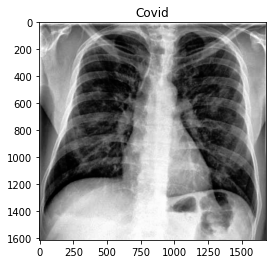

In [ ]:
index= 110
image, target=dset[index]

plt.title(class_list[target])
plt.imshow(image)

In [ ]:
len(dset)

251

**연산가능한 텐서형으로 변환**

In [ ]:
from torchvision import transforms

In [ ]:
transformer=transforms.Compose([
    transforms.ToTensor(),  # 텐서형으로 변환
    transforms.Resize((224,224)), # 변환된 이미지를 224*224로
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # 0과 1사이의 텐서값을 평균, std로 다시 정규화 값이 3개인 이유는 
])                                                                                                            # 각각 RGB에 해당하기 때문

In [ ]:
train_dset=Chest_dataset(train_data_dir, transformer)
index=200
image=train_dset[index][0]
target=train_dset[index][1]
print(image.shape)
print(target)

torch.Size([3, 224, 224])
tensor([2])


**데이터로더 구현**

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_data_dir='/content/drive/MyDrive/pytorch 연습/files/covid19/Covid19-dataset/train'
val_data_dir='/content/drive/MyDrive/pytorch 연습/files/covid19/Covid19-dataset/train'

# train_dset=Chest_dataset(train_data_dir, transformer)
# train_dloader=DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)# drop_last는 데이터개수를 배치사이즈로 나눴을 때 
                                                                                # 남는걸 버릴지 쓸지 결정
# val_dset=Chest_dataset(val_data_dir, transformer)
# val_dloader=DataLoader(val_dset, batch_size=1, shuffle=False)
# 아래와 같이 함수로 구현하는게 더 깔끔하다

In [ ]:
def build_dataloader(train_data_dir, val_data_dir):
  dataloaders={}
  train_dset=Chest_dataset(train_data_dir, transformer)
  dataloaders['train']=DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
  val_dset=Chest_dataset(val_data_dir, transformer)
  dataloaders['val']=DataLoader(val_dset, batch_size=1, shuffle=False)
  return dataloaders

In [ ]:
dataloaders=build_dataloader(train_data_dir, val_data_dir)
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fd601ac5c70>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fd601ac5eb0>}


**classification 모델 (vgg19) 불러오기**

In [ ]:
from torchvision import models

In [ ]:
model=models.vgg19(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
con=models.convnext_base(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

In [ ]:
con

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
from torchsummary import summary
summary(model, (3,224,224), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

데이터에 맞도록 모델 head(출력) 부분 변겅

In [ ]:
import torch.nn as nn

In [ ]:
model.avgpool=nn.AdaptiveAvgPool2d(output_size=(1,1))
model.classifier=nn.Sequential( # sequential으로 아래 를 묶어줌
    nn.Flatten(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0,1), # 오버피팅 방지 dropout
    nn.Linear(256,3), #output 3개로 지정
    nn.Sigmoid() # 0과1사이 학률 
)

In [ ]:
def build_vgg19_based_model(device='cuda'):  # 위를 함수로 한번에 작성
  device=torch.device(device)
  model=models.vgg19(pretrained=True)
  model.avgpool=nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier=nn.Sequential( # sequential으로 아래 를 묶어줌
    nn.Flatten(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0,1), # 오버피팅 방지 dropout
    nn.Linear(256,3), #output 3개로 지정
    nn.Sigmoid() # 0과1사이 학률
  )
  return model.to(device)

In [ ]:
model=build_vgg19_based_model(device='cuda')

In [ ]:
summary(model, (3,224,224), batch_size=1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

In [ ]:
a=[0,1,2]
for i in range(0,len(a)+1):
  print(i)

0
1
2
3


In [ ]:
13%17

13